In [15]:
using PyPlot
using Cubature

include("DG_Functions.jl")
include("Specific_DG_Functions.jl")

#------------------------------------------------------
# 1-D Basis
#------------------------------------------------------

function v(k::Int, level::Int, place::Int, f_number::Int, x::Real)
	if level==0 # At the base level, we are not discontinuous, and we simply
                # use Legendre polynomials up to degree k-1 as a basis
		return LegendreP(f_number,2x-1)*sqrt(2.0)
	else
		return h(k, f_number, (1<<level)*x - (2*place-1)) * (2.0)^(level/2)
        # Otherwise we use an appropriately shifted, scaled, and normalized
		# DG function
	end
end

#------------------------------------------------------
# Tensor Product Construction
#------------------------------------------------------

# Returns the value of the function at x
function V{D,T<:Real}(k, level::NTuple{D,Int}, 
    place::CartesianIndex{D}, f_number::CartesianIndex{D}, xs::AbstractArray{T})
	ans = one(eltype(xs))
    for i = 1:D
        ans *= v(k, level[i], place[i], f_number[i], xs[i])
    end
    return ans
end
# Is there any fast way to precompute the ones I care about?? 

# Returns a function
function V{D}(k, level::NTuple{D,Int}, 
                place::CartesianIndex{D}, f_number::CartesianIndex{D})
    return (xs-> V(k, level, place, f_number, xs))
end

#------------------------------------------------------
# Quick plotting methods for 1-D and 2-D
#------------------------------------------------------

function plotfunc1D(f::Function)
    xs=linspace(0,1,300)
    # y = [f((x,)) for x in xs]
    ys=[f((x,)) for x in xs]
    surf=plot(xs,ys)
end

function plotfunc2D(f::Function)
    xs=linspace(0,1,250)'
    ys=linspace(0,1,250)
    zs=[f((x,y)) for x in xs, y in ys]
    surf=plot_surface(xs,ys,zs)
end

#------------------------------------------------------
# Methods for obtaining the coefficients
#------------------------------------------------------
# This function is just for special boundary cases to make sure
# that the number of coefficients for the constant & linear functions
# doesn't become non-positive
function pos(x::Int)
    if x >= 0
        return x
    else
        return 0
    end
end

# Given a 1-D position and level, this tells us which place 
# that position belongs to, at that level resolution
function hat_index(x::Float64,l::Int)
    if l<= 1
        return 1
    end
    if x>= 1
        return 2^(l-1)
    else
        return 1 + floor(Int, 2^(l-1) * x)
    end
end

# This takes an inner product, but since for higher levels our inner product
# is only concerned with a specific region in the grid, we restrict to that
# appropriately, depending on the level
function inner_product{D}(f::Function, g::Function, lvl::NTuple{D,Int}, place::CartesianIndex{D})
    xmin = ntuple(i-> (place[i]-1)*(0.5)^(-pos(lvl[i]-1)), D)
	xmax = ntuple(i-> (place[i])*(0.5)^(-pos(lvl[i]-1)), D)
	h = (x-> f(x)*g(x))
	(val, err) = hcubature(h, xmin, xmax;) #reltol=1e-8, abstol=0, maxevals=0
	return val 
end

# We obtain coefficients simply by doing inner products, it's easy :) 
# Only hard part is inner product integrations can be slower than we wante :(
function get_coefficient_DG{D}(k::Int, 
				f::Function, lvl::NTuple{D,Int}, place::CartesianIndex{D}, f_number::CartesianIndex{D})
    return inner_product(f, V(k,lvl,place,f_number),lvl,place)
end 

#------------------------------------------------------
# Hierarchical Galerkin Coefficients in n-D
#------------------------------------------------------
function hier_coefficients_DG{D}(k::Int, f::Function, ls::NTuple{D,Int})
    coeffs = Dict{CartesianIndex{D}, Array{Array{Float64},D}}()
	# We will make a dictionary, that given a level (represented by a cartesian index)
	# will lead to a list of coefficients representing the places at that level
	# and the array f_number telling us which basis element V we are looking at
	f_numbers= ntuple(i-> k, D)
    for level in CartesianRange(ls)     # This really goes from 0 to l_i for each i,
        ks = ntuple(i -> 1<<pos(level[i]-2), D)  #This sets up a specific k+2 vector
        level_coeffs = Array(Array{Float64},ks)	 #all the coefficients at this level
		lvl = ntuple(i -> level[i]-1,D)
        for place in CartesianRange(ks)
            level_coeffs[place]=Array(Float64,f_numbers)
			for f_number in CartesianRange(f_numbers)
                (level_coeffs[place])[f_number]=get_coefficient_DG(k,f,lvl,place,f_number)
                # The coefficients of this level at this place 
				# AND at this specific function are computed
            end
        end
        coeffs[level] = level_coeffs
    end
    return coeffs
end


#------------------------------------------------------
# Sparse Galerkin Coefficients in n-D
#------------------------------------------------------
function sparse_coefficients_DG(f::Function, n::Int, D::Int)
    coeffs = Dict{CartesianIndex{D}, Array{Array{Float64},D}}()
	f_numbers= ntuple(i-> k, D)
    ls = ntuple(i->(n+1),D)
    for level in CartesianRange(ls) #This really goes from 0 to l_i for each i
        diag_level=0;
        for i in 1:D
            diag_level+=level[i]
        end
        if diag_level > n + D #If we're past the levels we care about, don't compute coeffs
            continue
        else  #Otherwise we'll go ahead and DO IT. The same code follows as before.
	        ks = ntuple(i -> 1<<pos(level[i]-2), D)  #This sets up a specific k+2 vector
	        level_coeffs = Array(Array{Float64},ks)	#the coefficients for all the places at this level
			lvl = ntuple(i -> level[i]-1,D)
	        for place in CartesianRange(ks)
                level_coeffs[place]=Array(Float64,f_numbers)
				for f_number in CartesianRange(f_numbers)
	            	(level_coeffs[place])[f_number]=get_coefficient_DG(k,f,lvl,place,f_number)
				end
	        end
	        coeffs[level] = level_coeffs
        end
    end
    return coeffs
end


function reconstruct_DG{D,T<:Real}(k::Int,coefficients::Dict{CartesianIndex{D}, Array{Array{Float64},D}}, x::Array{T})
    value = 0.0
    f_numbers= ntuple(i-> k ,D)
    for key in keys(coefficients)	#For every level that has coefficients
        level = ntuple(i->key[i]-1,D)	# Get the actual level corresponding to that CartesianIndex
        place = CartesianIndex{D}(ntuple(i->hat_index(x[i],level[i]),D))
        # Get the relevant place for our position x
		for f_number in CartesianRange(f_numbers)
        	value += (coefficients[key])[CartesianIndex{D}(place)][f_number]*V(k,level,place,f_number,x)
		end 
		#get the appropriate coefficient and evaluate the appropriate ϕ at x
    end
    return value	#return the sum of all the relevant hat functions at that place x
end

reconstruct_DG (generic function with 1 method)

In [11]:
coeffs=hier_coefficients_DG(3,(x-> sin(pi*x[1]+x[2])),(3,3))

Dict{CartesianIndex{2},Array{Array{Float64,N},2}} with 9 entries:
  CartesianIndex{2}((3,3)) => 2x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,3)) => 1x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((3,1)) => 2x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((3,2)) => 2x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,2)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,1)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,1)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,3)) => 1x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,2)) => 1x1 Array{Array{Float64,N},2}:…

In [12]:
coeffs = Out[11]
typeof(coeffs)

Dict{CartesianIndex{2},Array{Array{Float64,N},2}}

In [13]:
coeffs[CartesianIndex{2}((1,1))]

1x1 Array{Array{Float64,N},2}:
 3x3 Array{Float64,2}:
 -0.173429    0.0123198    0.00191355 
  0.0414725   0.00987135  -0.000457591
  0.0210003  -0.00149179  -0.000231708

In [20]:
tic()
inner_product(V(3, (3,3),CartesianIndex{2}((2,1)),CartesianIndex{2}((2,2))),
V(3, (3,3),CartesianIndex{2}((2,1)),CartesianIndex{2}((2,2))),(1,1),CartesianIndex{2}((1,1)))
toq()

0.488035514

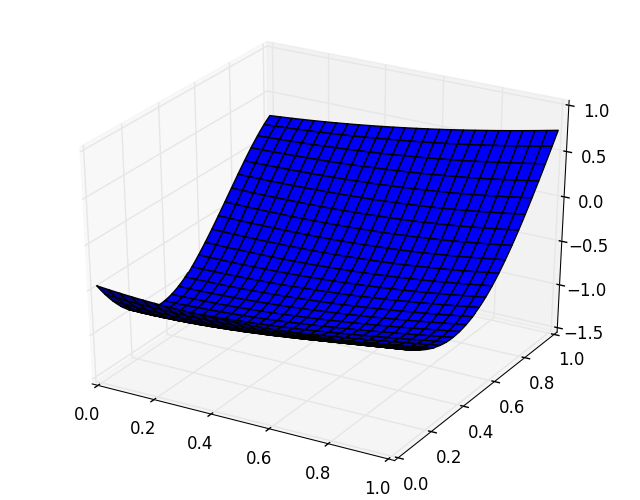

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x3249a5fd0>

In [21]:
plotfunc2D(x->reconstruct_DG(3, coeffs, [x[1],x[2]])-sin(pi*x[1]+x[2]))

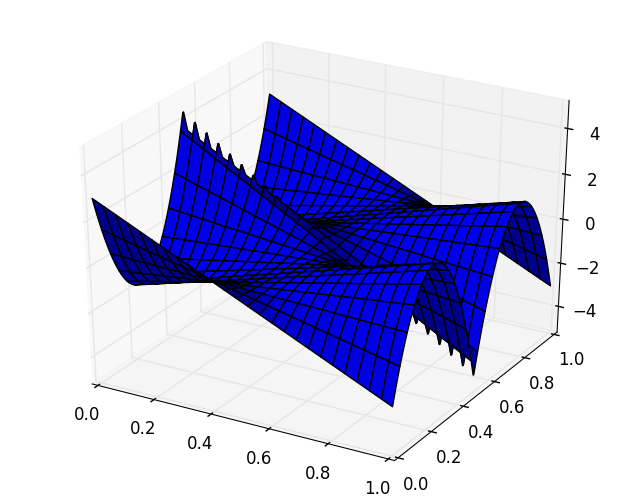

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x31e3123d0>

In [3]:
#get_coefficient_DG(3,(x-> sin(pi*x[1]+x[2])),(1,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,1)))
#inner_product((x-> sin(pi*x[1]+x[2])), V(k,lvl,place,f_number),lvl,place)
#plotfunc2D(V(3,(1,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,1))))
plotfunc2D(x->V(3,(1,0),CartesianIndex{2}((1,1)),CartesianIndex{2}((2,1)),[x[1],x[2]]))

In [ ]:
using PyPlot
using Cubature

include("DG_Functions.jl")
include("Specific_DG_Functions.jl")

#------------------------------------------------------
# 1-D Basis
#------------------------------------------------------

function v(k::Int, level::Int, place::Int, f_number::Int, x::Real)
	if level==0 #At the base level, we are not discontinuous, and we simply
				#use Legendre polynomials up to degree k-1 as a basis
		return LegendreP(f_number,2x-1)*sqrt(2.0)
	else
		return h(k, f_number, (1<<level)*x - (2*place-1)) * (2.0)^(level/2)
		# Otherwise we use an appropriately shifted, scaled, and normalized
		# DG function
	end
end

#------------------------------------------------------
# Tensor Product Construction
#------------------------------------------------------

# Returns the value of the function at x
function V{D,T<:Real}(k, level::NTuple{D,Int}, 
                place::CartesianIndex{D}, f_number::CartesianIndex{D}, xs::NTuple{D,T})
	ans = one(eltype(xs))
    for k = 1:D
        ans *= v(k, level[k], place[k], f_number[k], xs[k])
    end
    return ans
end
# Is there any fast way to precompute the ones I care about?? 

# Returns a function
function V{D}(k, level::NTuple{D,Int}, 
                place::CartesianIndex{D}, f_number::CartesianIndex{D})
    return (xs-> V(k, level, place, f_number, xs))
end

#------------------------------------------------------
# Quick plotting methods for 1-D and 2-D
#------------------------------------------------------

function plotfunc1D(f::Function)
    xs=linspace(0,1,300)
    # y = [f((x,)) for x in xs]
    ys=[f((x,)) for x in xs]
    surf=plot(xs,ys)
end

function plotfunc2D(f::Function)
    xs=linspace(0,1,250)'
    ys=linspace(0,1,250)
    zs=[f((x,y)) for x in xs, y in ys]
    surf=plot_surface(xs,ys,zs)
end

#------------------------------------------------------
# Methods for obtaining the coefficients
#------------------------------------------------------
# This function is just for special boundary cases to make sure
# that the number of coefficients for the constant & linear functions
# doesn't become non-positive
function pos(x::Int)
    if x >= 0
        return x
    else
        return 0
    end
end

# Given a 1-D position and level, this tells us which place 
# that position belongs to, at that level resolution
function hat_index(x::Float64,l::Int)
    if l<= 1
        return 1
    end
    if x>= 1
        return 2^(l-1)
    else
        return 1 + floor(Int, 2^(l-1) * x)
    end
end

# This takes an inner product, but since for higher levels our inner product
# is only concerned with a specific region in the grid, we restrict to that
# appropriately, depending on the level
function inner_product{D}(f::Function, g::Function,
		 		lvl::NTuple{D,Int}, place::CartesianIndex{D})
	xmin = tuple()
	xmax = tuple()
	h = (x-> f(x)*g(x))
	(val, err) = hcubature(h, xmin, xmax;) #reltol=1e-8, abstol=0, maxevals=0
	return value 
end

# We obtain coefficients simply by doing inner products, it's easy :) 
# Only hard part is inner product integrations can be slower than we wante :(
function get_coefficient_DG{D}(k::Int, 
				f::Function, lvl::NTuple{D,Int}, place::CartesianIndex{D}, f_number::Int)
	return inner_product(f, V(k,f_number),lvl,place)
end 

#------------------------------------------------------
# Hierarchical Galerkin Coefficients in n-D
#------------------------------------------------------
function hier_coefficients_DG{D}(k::Int, f::Function, ls::NTuple{D,Int})
    coeffs = Dict{CartesianIndex{D}, Array{Array{Float64},D}}()
	# We will make a dictionary, that given a level (represented by a cartesian index)
	# will lead to a list of coefficients representing the places at that level
	# and the array f_number telling us which basis element V we are looking at
	f_numbers= k*ones(Int,D)
    for level in CartesianRange(ls)     # This really goes from 0 to l_i for each i,
        ks = ntuple(i -> 1<<pos(level[i]-2), D)  #This sets up a specific k+1 vector
        level_coeffs = Array(Array{Float64},ks)	 #all the coefficients at this level
		lvl = ntuple(i -> level[i]-1,D)
        for place in CartesianRange(ks)
			for f_number in CartesianRange(f_numbers)
            	(level_coeffs[place])[f_number]=get_coefficient_DG(k,f,lvl,place,f_number)
				# The coefficients of this level at this place 
				# AND at this specific function are computed
            end
        end
        coeffs[level] = level_coeffs
		# We assign to this CartesianIndex{D} in the dictionary the corresponding
		# Array of Arrays 
    end
    return coeffs
end


#------------------------------------------------------
# Sparse Galerkin Coefficients in n-D
#------------------------------------------------------
function sparse_coefficients_DG(f::Function, n::Int, D::Int)
    coeffs = Dict{CartesianIndex{D}, Array{Array{Float64},D}}()
	f_numbers= k*ones(Int,D)
    ls = ntuple(i->(n+1),D)
    for level in CartesianRange(ls) #This really goes from 0 to l_i for each i
        diag_level=0;
        for i in 1:D
            diag_level+=level[i]
        end
        if diag_level > n + D #If we're past the levels we care about, don't compute coeffs
            continue
        else  #Otherwise we'll go ahead and DO IT. The same code follows as before.
	        ks = ntuple(i -> 1<<pos(level[i]-2), D)  #This sets up a specific k+2 vector
	        level_coeffs = Array(Array{Float64},ks)	#the coefficients for all the places at this level
			lvl = ntuple(i -> level[i]-1,D)
	        for place in CartesianRange(ks)
				for f_number in CartesianRange(f_numbers)
	            	(level_coeffs[place])[f_number]=get_coefficient_DG(k,f,lvl,place,f_number)
				end
	        end
	        coeffs[level] = level_coeffs
        end
    end
    return coeffs
end


function reconstruct_DG{D,T<:Real}(k::Int,coefficients::Dict{CartesianIndex{D}, Array{Float64,D}}, x::NTuple{D,T})
    value = 0.0
	f_numbers= k*ones(Int,D)
    for key in keys(coefficients)	#For every level that has coefficients
        level = ntuple(i->key[i]-2,D)	# Get the actual level corresponding to that CartesianIndex
        place = ntuple(i->hat_index(x[i],level[i]),D)  # Get the relevant place for our position x
		for f_number in CartesianRange(f_numbers)
        	value += (coefficients[key])[CartesianIndex{D}(place)][f_number]*V(k,level,place,f_number,x)
		end 
		#get the appropriate coefficient and evaluate the appropriate ϕ at x
    end
    return value	#return the sum of all the relevant hat functions at that place x
end